In [ ]:
!pip install -q git+https://github.com/RobustBench/robustbench.git

In [ ]:
# ============================================
# Install dependencies
# ============================================
!pip install -q gdown torchsummary huggingface_hub captum

In [4]:
# ============================================
# Import libraries
# ============================================
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset, Subset, WeightedRandomSampler
from torchsummary import summary
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from PIL import ImageFile, Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import gc
from huggingface_hub import HfApi, login, create_repo, hf_hub_download
from kaggle_secrets import UserSecretsClient
from robustbench.utils import load_model
from captum.attr import Saliency, DeepLift, IntegratedGradients, Occlusion
import torchvision.transforms.functional as F
import json
import glob
import types

In [5]:
# ---------------------------
# Setup
# ---------------------------
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)

os.makedirs("/kaggle/working/satellite_xai", exist_ok=True)
%cd /kaggle/working/satellite_xai

data_root = "/kaggle/input/dior-r-dataset-yolov11-obb-format/YOLODIOR-R"

/kaggle/working/satellite_xai


In [6]:
# Full list of 20 classes (given in dataset)
all_classes = [
    "airplane", "airport", "baseballfield", "basketballcourt", "bridge",
    "chimney", "dam", "Expressway-Service-area", "Expressway-toll-station",
    "golffield", "groundtrackfield", "harbor", "overpass", "ship",
    "stadium", "storagetank", "tenniscourt", "trainstation",
    "vehicle", "windmill"
]

# Select only 10 classes (can change later)
selected_class_ids = [0, 1, 4, 10, 11, 13, 14, 15, 17, 18]
selected_classes = [all_classes[i] for i in selected_class_ids]
print("Selected classes:", selected_classes)

Selected classes: ['airplane', 'airport', 'bridge', 'groundtrackfield', 'harbor', 'ship', 'stadium', 'storagetank', 'trainstation', 'vehicle']


In [7]:
# ---------------------------
# Custom Dataset for YOLO format (Modified to filter single-class images)
# ---------------------------
class YoloOBBDataset(Dataset):
    def __init__(self, img_dir, label_dir, selected_class_ids, transform=None, single_class_only=True):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.single_class_only = single_class_only
        
        # Create mapping from original class IDs to continuous indices [0, 9]
        self.class_id_to_idx = {original_id: idx for idx, original_id in enumerate(selected_class_ids)}
        
        self.samples = []
        for fname in os.listdir(img_dir):
            if fname.endswith(".jpg"):
                img_path = os.path.join(img_dir, fname)
                lbl_path = os.path.join(label_dir, fname.replace(".jpg", ".txt"))
                if os.path.exists(lbl_path):
                    with open(lbl_path, "r") as f:
                        labels = []
                        classes_in_image = set()
                        
                        for line in f.readlines():
                            parts = line.strip().split()
                            original_cls = int(parts[0])
                            if original_cls in selected_class_ids:
                                # Map to continuous index [0, 9]
                                mapped_cls = self.class_id_to_idx[original_cls]
                                coords = list(map(float, parts[1:]))
                                labels.append((mapped_cls, coords))  # Store mapped class
                                classes_in_image.add(mapped_cls)
                        
                        if self.single_class_only:
                            if len(labels) > 0 and len(classes_in_image) == 1:
                                self.samples.append((img_path, labels))
                        else:
                            if len(labels) > 0:
                                self.samples.append((img_path, labels))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, labels = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
    
        formatted = []
        for cls, coords in labels:
            formatted.append([cls] + coords)
    
        target = torch.tensor(formatted, dtype=torch.float32)
        return image, target

In [8]:
# ---------------------------
# Transforms (just resize + tensor, no augmentation)
# ---------------------------
import torchvision.transforms as transforms

normalize_transform = transforms.Normalize(
    mean=[0.5071, 0.4865, 0.4409],
    std=[0.2673, 0.2564, 0.2762]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize_transform
])

In [9]:
# ---------------------------
# Dataset Creation (Modified for single-class filtering)
# ---------------------------
datasets_dict = {}
for split in ["train", "val", "test"]:
    img_dir = os.path.join(data_root, split, "images")
    lbl_dir = os.path.join(data_root, split, "labels")
    datasets_dict[split] = YoloOBBDataset(
        img_dir, 
        lbl_dir, 
        selected_class_ids, 
        transform=transform,
        single_class_only=True  # Enable single-class filtering
    )
    print(f"{split} dataset: {len(datasets_dict[split])} images with exactly one class from selected classes")

train dataset: 9268 images with exactly one class from selected classes
val dataset: 1145 images with exactly one class from selected classes
test dataset: 1156 images with exactly one class from selected classes


In [10]:
# Custom collate function for variable-sized targets
def collate_fn(batch):
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        targets.append(target)
    
    # Stack images (they should all be the same size due to transforms)
    images = torch.stack(images, 0)
    
    return images, targets

In [11]:
# ---------------------------
# Subset selection
# ---------------------------
subset_sizes = {"train": 2500, "val": 300, "test": 300}
subset_datasets = {}

for split in ["train", "val", "test"]:
    full_len = len(datasets_dict[split])
    target_len = min(subset_sizes[split], full_len)
    indices = random.sample(range(full_len), target_len)
    subset_datasets[split] = Subset(datasets_dict[split], indices)
    print(f"{split} subset: {len(subset_datasets[split])}")

# ---------------------------
# DataLoaders
# ---------------------------
batch_size = 8
dl_train = DataLoader(subset_datasets["train"], batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
dl_val   = DataLoader(subset_datasets["val"], batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
dl_test  = DataLoader(subset_datasets["test"], batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

print("DataLoaders ready.")

train subset: 2500
val subset: 300
test subset: 300
DataLoaders ready.


In [12]:
class_names = {}
for class_id in selected_class_ids:
    class_names[class_id] = all_classes[class_id]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Function to denormalize (undo ImageNet-like normalization for display)
def denormalize(img_tensor):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std  = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.numpy().transpose((1, 2, 0))   # CHW -> HWC
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_batch(dataloader, class_names_dict, n=4):
    images, targets = next(iter(dataloader))
    
    plt.figure(figsize=(14, 8))
    for i in range(min(n, len(images))):
        ax = plt.subplot(2, n//2, i+1)
        img = denormalize(images[i].cpu())
        ax.imshow(img)
        ax.axis("off")
        
        img_height, img_width = img.shape[:2]
        t = targets[i]
        
        if t.ndim == 1:
            t = t.unsqueeze(0)

        for obj_idx in range(len(t)):
            obj = t[obj_idx]
            cls_id = int(obj[0].item())
            
            coords = obj[1:].view(4, 2).numpy()
            coords[:, 0] *= img_width
            coords[:, 1] *= img_height

            polygon = plt.Polygon(coords, fill=False, edgecolor="red", linewidth=1.5)
            ax.add_patch(polygon)

            # Use the dictionary lookup
            class_name = class_names_dict.get(cls_id, f"cls {cls_id}")
                
            ax.text(coords[0, 0], coords[0, 1], class_name,
                    color="yellow", fontsize=8, weight="bold", 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))

    plt.tight_layout()
    plt.show()

# Usage
show_batch(dl_train, class_names, n=8)

Train the model

In [18]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load pretrained model
model = load_model(
    model_name='Chen2024Data_WRN_34_10',
    dataset='cifar100',
    threat_model='Linf'
)

# 2) Replace the final Linear head with a 10-class MLP
def find_last_linear(m: nn.Module):
    last_name, last_linear = None, None
    for name, mod in m.named_modules():
        if isinstance(mod, nn.Linear):
            last_name, last_linear = name, mod
    if last_linear is None:
        raise RuntimeError("No Linear classifier found to replace.")
    return last_name, last_linear

def set_by_name(root: nn.Module, dotted: str, new_module: nn.Module):
    parts = dotted.split(".")
    parent = root
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_module)

last_name, last_linear = find_last_linear(model)
in_features = last_linear.in_features

new_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 10)  # logits for 10 classes
)
set_by_name(model, last_name, new_head)

# 3) Freeze backbone; train only the new head
for p in model.parameters():
    p.requires_grad = False
for p in new_head.parameters():
    p.requires_grad = True

# 4) Monkey-patch forward to use adaptive GAP (no image resizing needed)
def patch_wideresnet_forward(model):
    """Recursively find and patch WideResNet's forward to use adaptive pooling"""
    for name, module in model.named_modules():
        # Check if this is a WideResNet instance
        if (hasattr(module, 'conv1') and hasattr(module, 'block1') and 
            hasattr(module, 'block2') and hasattr(module, 'block3') and
            hasattr(module, 'fc') and hasattr(module, 'nChannels')):
            
            print(f"Found WideResNet at: {name if name else 'root'}")
            
            def new_forward(self, x):
                out = self.conv1(x)
                out = self.block1(out)
                out = self.block2(out)
                out = self.block3(out)
                out = self.relu(self.bn1(out))
                # Use adaptive pooling instead of fixed 8x8
                out = F.adaptive_avg_pool2d(out, (1, 1))
                out = torch.flatten(out, 1)
                return self.fc(out)
            
            module.forward = types.MethodType(new_forward, module)
            print("✅ Patched WideResNet forward method")
            return True
    
    return False

patch_wideresnet_forward(model)

# 5) Move everything to device; keep backbone eval, head train
model = model.to(device)

Found WideResNet at: root
✅ Patched WideResNet forward method


In [19]:
# -------------------------
# Handle Class Imbalance
# -------------------------
# (Handled by oversampling, no need for loss weights)
criterion = nn.CrossEntropyLoss()

# -------------------------
# Optimizer
# -------------------------
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [20]:
# -------------------------
# Training Loop with Best Model Saving (Fixed for class mapping)
# -------------------------
def train_model(model, criterion, optimizer, num_epochs=15, save_path="best_data_filtering_wrn_34_20.pth", patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        stop_training = False

        # Each epoch has training + validation
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = dl_train
            else:
                model.eval()
                dataloader = dl_val

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            it = tqdm(dataloader, desc=f"{phase} Epoch {epoch+1}/{num_epochs}")

            for batch_idx, (inputs, targets_list) in enumerate(dataloader):
                # Move inputs to device
                inputs = inputs.to(device)
                
                # Extract and map class labels
                batch_labels = []
                for target in targets_list:
                    if len(target) > 0:
                        mapped_class_idx = int(target[0, 0].item())
                        batch_labels.append(mapped_class_idx)
                    else:
                        batch_labels.append(0)  # Fallback
                
                # Convert to tensor and move to device
                labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data)
                total_samples += batch_size

                # Update tqdm postfix with current loss and acc
                current_loss = running_loss / total_samples if total_samples > 0 else 0
                current_acc = (running_corrects.double() / total_samples) if total_samples > 0 else 0
                
                it.set_postfix(
                    loss=current_loss,
                    acc=current_acc.item()
                )

            it.close()

            epoch_loss = running_loss / total_samples if total_samples > 0 else 0
            epoch_acc = running_corrects.double() / total_samples if total_samples > 0 else 0

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Check for improvement
            if phase == "val":
                if epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, save_path)
                    print(f"✅ Best model updated and saved at {save_path}")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)")

                # Early stopping
                if epochs_no_improve >= patience:
                    print(f"⏹️ Early stopping triggered (no improvement for {patience} epochs).")
                    stop_training = True

        if stop_training:
            break

    print(f"\nBest val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [21]:
# -------------------------
# Run Training
# -------------------------
trained_model = train_model(model, criterion, optimizer, num_epochs=25, patience=3)


Epoch 1/25


train Epoch 1/25:   0%|          | 0/313 [02:41<?, ?it/s, acc=0.444, loss=1.68] 


train Loss: 1.6766 Acc: 0.4440


val Epoch 1/25:   0%|          | 0/38 [00:19<?, ?it/s, acc=0.577, loss=1.21]


val Loss: 1.2088 Acc: 0.5767
✅ Best model updated and saved at best_data_filtering_wrn_34_20.pth

Epoch 2/25


train Epoch 2/25:   0%|          | 0/313 [02:43<?, ?it/s, acc=0.515, loss=1.41]


train Loss: 1.4135 Acc: 0.5152


val Epoch 2/25:   0%|          | 0/38 [00:19<?, ?it/s, acc=0.597, loss=1.27]


val Loss: 1.2705 Acc: 0.5967
✅ Best model updated and saved at best_data_filtering_wrn_34_20.pth

Epoch 3/25


train Epoch 3/25:   0%|          | 0/313 [02:43<?, ?it/s, acc=0.52, loss=1.36] 


train Loss: 1.3642 Acc: 0.5200


val Epoch 3/25:   0%|          | 0/38 [00:19<?, ?it/s, acc=0.623, loss=1.14]


val Loss: 1.1366 Acc: 0.6233
✅ Best model updated and saved at best_data_filtering_wrn_34_20.pth

Epoch 4/25


train Epoch 4/25:   0%|          | 0/313 [02:45<?, ?it/s, acc=0.525, loss=1.36]


train Loss: 1.3627 Acc: 0.5252


val Epoch 4/25:   0%|          | 0/38 [00:19<?, ?it/s, acc=0.567, loss=1.17]


val Loss: 1.1664 Acc: 0.5667
⚠️ No improvement for 1 epoch(s)

Epoch 5/25


train Epoch 5/25:   0%|          | 0/313 [02:44<?, ?it/s, acc=0.536, loss=1.35]


train Loss: 1.3546 Acc: 0.5360


val Epoch 5/25:   0%|          | 0/38 [00:19<?, ?it/s, acc=0.62, loss=1.11]  


val Loss: 1.1079 Acc: 0.6200
⚠️ No improvement for 2 epoch(s)

Epoch 6/25


train Epoch 6/25:   0%|          | 0/313 [02:46<?, ?it/s, acc=0.519, loss=1.36]


train Loss: 1.3605 Acc: 0.5188


val Epoch 6/25:   0%|          | 0/38 [00:19<?, ?it/s, acc=0.57, loss=1.21]  

val Loss: 1.2062 Acc: 0.5700
⚠️ No improvement for 3 epoch(s)
⏹️ Early stopping triggered (no improvement for 3 epochs).

Best val Acc: 0.6233


In [24]:
# -------------------------
# Upload the best model to huggingface
# -------------------------
# Get token and login
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
login(token=hf_token)
print("✅ Logged in to Hugging Face")

# Create the repository first (only needed once)
repo_id = "MohammadFazli/xAI-remote-sensing-dior-model"
try:
    create_repo(
        repo_id=repo_id,
        token=hf_token,
        private=False,  # Set to True if you want a private repo
        repo_type="model"
    )
    print(f"✅ Repository created: {repo_id}")
except Exception as e:
    print(f"ℹ️  Repository might already exist: {e}")

# Save model (uncomment if not already saved)
local_path = "/kaggle/working/satellite_xai/best_data_filtering_wrn_34_20.pth"
# torch.save(model.state_dict(), local_path)

# Verify file exists
if not os.path.exists(local_path):
    raise FileNotFoundError(f"Model file not found at: {local_path}")
else:
    file_size = os.path.getsize(local_path) / (1024 * 1024)  # MB
    print(f"✅ Model file found: {file_size:.2f} MB")

# Upload to Hugging Face
print("📤 Uploading to Hugging Face...")
api = HfApi()
api.upload_file(
    path_or_fileobj=local_path,
    path_in_repo="best_data_filtering_wrn_34_20.pth",
    repo_id=repo_id,
    repo_type="model",
    token=hf_token
)

print("✅ Model uploaded to Hugging Face Hub!")
print(f"🔗 Access at: https://huggingface.co/{repo_id}")

✅ Logged in to Hugging Face
ℹ️  Repository might already exist: Client error '409 Conflict' for url 'https://huggingface.co/api/repos/create' (Request ID: Root=1-68f25996-655cc772736c23ff74dd8139;fdde2e8f-d245-49c5-b3b5-ac5c025fbe9d)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/409

You already created this model repo: MohammadFazli/xAI-remote-sensing-dior-model
✅ Model file found: 177.50 MB
📤 Uploading to Hugging Face...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Model uploaded to Hugging Face Hub!
🔗 Access at: https://huggingface.co/MohammadFazli/xAI-remote-sensing-dior-model


Evaluation

In [12]:
# ================================
# Eval: RobustBench + 10-class head
# ================================
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load base model
base = load_model(
    model_name='Chen2024Data_WRN_34_10',
    dataset='cifar100',
    threat_model='Linf'
)

# --- Replace final Linear with 10-class MLP (same as training) ---
def find_last_linear(m: nn.Module):
    last_name, last_linear = None, None
    for name, mod in m.named_modules():
        if isinstance(mod, nn.Linear):
            last_name, last_linear = name, mod
    if last_linear is None:
        raise RuntimeError("No Linear classifier found to replace.")
    return last_name, last_linear

def set_by_name(root: nn.Module, dotted: str, new_module: nn.Module):
    parts = dotted.split(".")
    parent = root
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_module)

last_name, last_linear = find_last_linear(base)
in_features = last_linear.in_features
new_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
set_by_name(base, last_name, new_head)

# --- Patch WideResNet forward (same as training) ---
def patch_wideresnet_forward(model):
    """Recursively find and patch WideResNet's forward to use adaptive pooling"""
    for name, module in model.named_modules():
        # Check if this is a WideResNet instance
        if (hasattr(module, 'conv1') and hasattr(module, 'block1') and 
            hasattr(module, 'block2') and hasattr(module, 'block3') and
            hasattr(module, 'fc') and hasattr(module, 'nChannels')):
            
            print(f"Found WideResNet at: {name if name else 'root'}")
            
            def new_forward(self, x):
                out = self.conv1(x)
                out = self.block1(out)
                out = self.block2(out)
                out = self.block3(out)
                out = self.relu(self.bn1(out))
                # Use adaptive pooling instead of fixed 8x8
                out = F.adaptive_avg_pool2d(out, (1, 1))
                out = torch.flatten(out, 1)
                return self.fc(out)
            
            module.forward = types.MethodType(new_forward, module)
            print("✅ Patched WideResNet forward method")
            return True
    
    return False

patch_wideresnet_forward(base)

# --- Load fine-tuned weights ---
# checkpoint_path = "/kaggle/working/xAI/best_data_filtering_wrn_34_20.pth"
checkpoint_path = hf_hub_download(
    repo_id="MohammadFazli/xAI-remote-sensing-dior-model",
    filename="best_data_filtering_wrn_34_20.pth"
)
state = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

# Load the state dict
base.load_state_dict(state, strict=True)

# Move to device and set to eval mode
model = base.to(device)
model.eval()

print(f"✅ Loaded fine-tuned weights from: {checkpoint_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1-N5a0Z9o-8-oIrF4_EaVFVOOPI5-D-H2
From (redirected): https://drive.google.com/uc?id=1-N5a0Z9o-8-oIrF4_EaVFVOOPI5-D-H2&confirm=t&uuid=205b3257-a557-40a6-ab65-94ac337a2c45
To: /kaggle/working/satellite_xai/models/cifar100/Linf/Chen2024Data_WRN_34_10.pt
100%|██████████| 185M/185M [00:03<00:00, 56.7MB/s] 


Found WideResNet at: root
✅ Patched WideResNet forward method


best_data_filtering_wrn_34_20.pth:   0%|          | 0.00/186M [00:00<?, ?B/s]

✅ Loaded fine-tuned weights from: /root/.cache/huggingface/hub/models--MohammadFazli--xAI-remote-sensing-dior-model/snapshots/f993ed6048c6bd146c90ecd0b3a285117ebf1105/best_data_filtering_wrn_34_20.pth


In [26]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion=None, class_names=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    all_labels, all_preds = [], []
    total_samples, running_loss = 0, 0.0
    
    for inputs, targets_list in tqdm(dataloader, desc="Evaluating", leave=False):
        inputs = inputs.to(device)
        
        batch_labels = []
        for target in targets_list:
            if isinstance(target, torch.Tensor) and target.numel() > 0:
                mapped_class_idx = int(target[0, 0].item())
                batch_labels.append(mapped_class_idx)
            else:
                batch_labels.append(0)
        
        labels = torch.tensor(batch_labels, dtype=torch.long, device=device)
        outputs = model(inputs)
        
        if criterion is not None:
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
        
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())
        total_samples += labels.size(0)
    
    # Metrics
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    acc = (all_preds == all_labels).mean() * 100.0
    avg_loss = (running_loss / total_samples) if (criterion is not None and total_samples > 0) else None
    
    print("========================================")
    print(f"✅ Test Accuracy: {acc:.2f}%")
    if avg_loss is not None:
        print(f"💡 Average Loss: {avg_loss:.4f}")
    print("========================================")
    
    # Determine all possible labels (0 to num_classes-1)
    num_classes = len(class_names) if class_names is not None else max(max(all_labels), max(all_preds)) + 1
    all_class_labels = list(range(num_classes))
    
    # Classification report
    if class_names is not None:
        print("\n📊 Classification Report:")
        print(classification_report(all_labels, all_preds, 
                                   labels=all_class_labels,  # Add this
                                   target_names=class_names,
                                   zero_division=0))  # Handle classes with no predictions
    else:
        print("\n📊 Classification Report:")
        print(classification_report(all_labels, all_preds, zero_division=0))
    
    print("\n🔢 Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds, labels=all_class_labels))  # Add labels here too
    
    return acc, all_preds, all_labels

In [27]:
# Create class_names mapping (mapped indices [0-9] to class names)
class_names = [all_classes[i] for i in selected_class_ids]
print("Class names for evaluation:", class_names)
# Output: ['airplane', 'airport', 'bridge', 'groundtrackfield', 'harbor', 
#          'ship', 'stadium', 'storagetank', 'trainstation', 'vehicle']

# Call the evaluation function
test_acc, test_preds, test_labels = evaluate_model(
    model=trained_model,
    dataloader=dl_test,
    criterion=criterion,
    class_names=class_names,
    device=device
)

Class names for evaluation: ['airplane', 'airport', 'bridge', 'groundtrackfield', 'harbor', 'ship', 'stadium', 'storagetank', 'trainstation', 'vehicle']


✅ Test Accuracy: 57.33%
💡 Average Loss: 1.1602

📊 Classification Report:
                  precision    recall  f1-score   support

        airplane       0.82      0.60      0.69        15
         airport       0.60      0.58      0.59        26
          bridge       0.56      0.20      0.29        25
groundtrackfield       0.60      0.18      0.28        33
          harbor       0.00      0.00      0.00         0
            ship       0.69      0.60      0.64        30
         stadium       0.00      0.00      0.00        14
     storagetank       0.41      0.36      0.39        33
    trainstation       0.65      0.75      0.70        20
         vehicle       0.55      0.88      0.68       104

       micro avg       0.57      0.57      0.57       300
       macro avg       0.49      0.42      0.43       300
    weighted avg       0.55      0.57      0.53       300


🔢 Confusion Matrix:
[[ 9  1  0  0  0  3  0  1  0  1]
 [ 0 15  1  0  0  2  0  1  0  7]
 [ 0  2  5  0  0  0  0  1

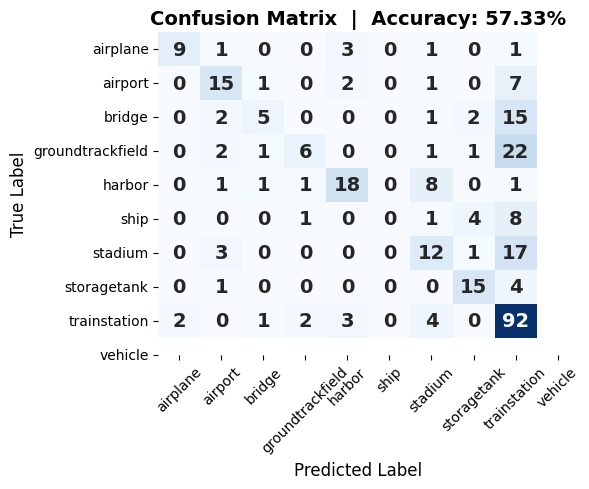

In [28]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
acc = (test_labels == test_preds).mean() * 100

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False,
    annot_kws={"size": 14, "weight": "bold"}
)
plt.title(f"Confusion Matrix  |  Accuracy: {acc:.2f}%", fontsize=14, weight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Attack

In [13]:
# ---------------------------
# DataLoaders
# ---------------------------
batch_size = 1

dl_test  = DataLoader(subset_datasets["test"], batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
print(f"Test: {len(dl_test)}")

Test: 300


In [31]:
eps = 4/255.0        # L_inf epsilon
alpha = 1/255.0      # step size
steps = 10            # PGD steps
random_start = True  # random init inside L_inf ball

# ImageNet normalization statistics (what your transform uses)
IMAGENET_MEAN = torch.tensor([0.5071, 0.4865, 0.4409])
IMAGENET_STD = torch.tensor([0.2673, 0.2564, 0.2762])

# ---------- Helpers ----------
def _maybe_repeat_to_three(x):
    """If input has 1 channel, repeat to 3 channels (model expects 3)."""
    if x.dim() == 4 and x.size(1) == 1:
        return x.repeat(1, 3, 1, 1)
    return x

def pgd_linf_batch_simple(model, x_orig, y, eps, alpha, steps, random_start=True):
    """
    PGD attack for normalized images.
    x_orig: [B,C,H,W] - NORMALIZED images (using ImageNet normalization)
    y: [B] long labels
    returns x_adv: adversarial examples in normalized space
    """
    device = x_orig.device
    
    # Get normalization parameters
    mean = IMAGENET_MEAN.view(1, 3, 1, 1).to(device)
    std = IMAGENET_STD.view(1, 3, 1, 1).to(device)
    
    # Calculate valid range in normalized space
    # (0 - mean) / std  to  (1 - mean) / std
    lower_limit = (0 - mean) / std
    upper_limit = (1 - mean) / std
    
    # Handle single-channel images
    if x_orig.size(1) == 1:
        lower_limit = lower_limit[:, 0:1, :, :]
        upper_limit = upper_limit[:, 0:1, :, :]
    
    x_orig = x_orig.detach()
    
    if random_start:
        x_adv = x_orig + torch.empty_like(x_orig).uniform_(-eps, eps)
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    else:
        x_adv = x_orig.clone().detach()
    
    loss_fn = nn.CrossEntropyLoss()
    
    for _ in range(steps):
        x_adv.requires_grad_()
        xin = _maybe_repeat_to_three(x_adv)
        logits = model(xin)
        loss = loss_fn(logits, y)
        
        model.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.data.zero_()
        loss.backward()
        
        grad = x_adv.grad.detach()
        x_adv = x_adv.detach() + alpha * torch.sign(grad)
        
        # Project to L_inf ball around original
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        
        # Clamp to valid normalized range
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    
    return x_adv.detach()

In [32]:
# ---------- Run attack on dl_test and collect preds/labels ----------
model.eval()

all_adv_preds = []
all_adv_labels = []

for inputs, targets_list in tqdm(dl_test, desc=f"PGD eps={eps} steps={steps}"):
    inputs = inputs.to(device, non_blocking=True)
    
    # Extract labels from targets_list (same as in training/evaluation)
    batch_labels = []
    for target in targets_list:
        if isinstance(target, torch.Tensor) and target.numel() > 0:
            mapped_class_idx = int(target[0, 0].item())
            batch_labels.append(mapped_class_idx)
        else:
            batch_labels.append(0)
    
    labels = torch.tensor(batch_labels, dtype=torch.long, device=device)

    # Make adversarial examples for this batch
    x_adv = pgd_linf_batch_simple(model, inputs, labels, eps=eps, alpha=alpha, steps=steps, random_start=random_start)

    # Evaluate on adversarial examples
    with torch.no_grad():
        logits_adv = model(_maybe_repeat_to_three(x_adv))
        preds_adv = torch.argmax(logits_adv, dim=1)

    all_adv_preds.append(preds_adv.cpu().numpy())
    all_adv_labels.append(labels.cpu().numpy())

    del inputs, labels, x_adv, logits_adv, preds_adv
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Concatenate results
all_adv_preds = np.concatenate(all_adv_preds)
all_adv_labels = np.concatenate(all_adv_labels)

PGD eps=0.01568627450980392 steps=10: 100%|██████████| 300/300 [11:23<00:00,  2.28s/it]


Class names: ['airplane', 'airport', 'bridge', 'groundtrackfield', 'harbor', 'ship', 'stadium', 'storagetank', 'trainstation', 'vehicle']

=== Adversarial test set metrics (PGD L_inf eps=0.01568627450980392, steps=10) ===
Accuracy: 0.4300

Classification report (per-class + macro & weighted):
                  precision    recall  f1-score   support

        airplane     0.5714    0.5333    0.5517        15
         airport     0.4211    0.3077    0.3556        26
          bridge     0.2500    0.0800    0.1212        25
groundtrackfield     0.3846    0.1515    0.2174        33
          harbor     0.0000    0.0000    0.0000         0
            ship     0.4167    0.3333    0.3704        30
         stadium     0.0000    0.0000    0.0000        14
     storagetank     0.2250    0.2727    0.2466        33
    trainstation     0.6364    0.7000    0.6667        20
         vehicle     0.4562    0.7019    0.5530       104

       micro avg     0.4300    0.4300    0.4300       300
       m

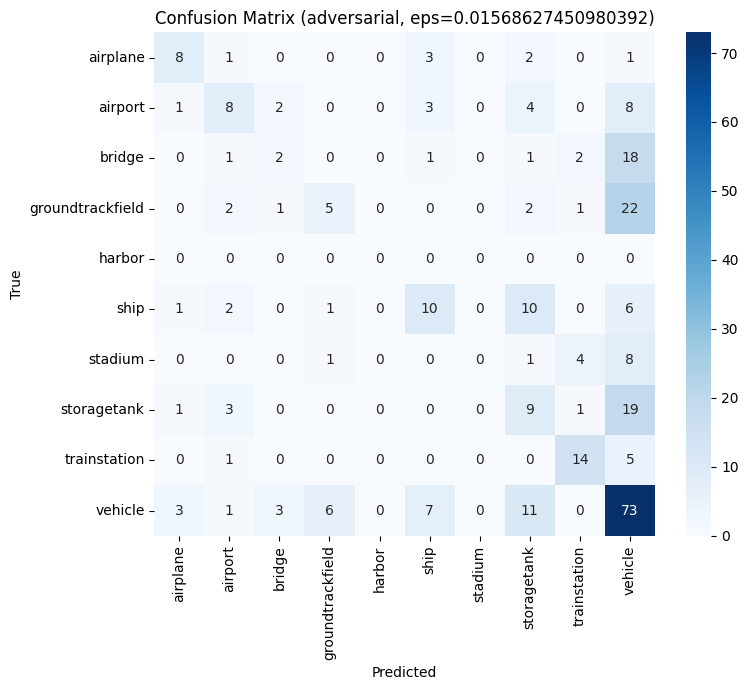


Macro-avg: precision=0.3361, recall=0.3081, f1=0.3083
Weighted-avg: precision=0.3952, recall=0.4300, f1=0.3927


In [33]:
# ---------- Compute & print metrics ----------
# Use YOUR 10 selected classes
class_names = [all_classes[i] for i in selected_class_ids]
print("Class names:", class_names)

# Specify all class labels [0-9] to handle missing classes
all_class_labels = list(range(10))

acc = accuracy_score(all_adv_labels, all_adv_preds)
report_dict = classification_report(all_adv_labels, all_adv_preds, 
                                   labels=all_class_labels,
                                   target_names=class_names, 
                                   digits=4, 
                                   output_dict=True,
                                   zero_division=0)
report_str = classification_report(all_adv_labels, all_adv_preds, 
                                  labels=all_class_labels,
                                  target_names=class_names, 
                                  digits=4,
                                  zero_division=0)
cm = confusion_matrix(all_adv_labels, all_adv_preds, labels=all_class_labels)

print(f"\n=== Adversarial test set metrics (PGD L_inf eps={eps}, steps={steps}) ===")
print(f"Accuracy: {acc:.4f}\n")
print("Classification report (per-class + macro & weighted):")
print(report_str)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

# Confusion heatmap
plt.figure(figsize=(8,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (adversarial, eps={eps})")
plt.tight_layout()
plt.show()

# Macro & weighted scores
macro_p = report_dict['macro avg']['precision']
macro_r = report_dict['macro avg']['recall']    
macro_f1 = report_dict['macro avg']['f1-score']
w_p = report_dict['weighted avg']['precision']
w_r = report_dict['weighted avg']['recall']
w_f1 = report_dict['weighted avg']['f1-score']

print(f"\nMacro-avg: precision={macro_p:.4f}, recall={macro_r:.4f}, f1={macro_f1:.4f}")
print(f"Weighted-avg: precision={w_p:.4f}, recall={w_r:.4f}, f1={w_f1:.4f}")

Interpretability

In [14]:
def compute_saliency_map(image, model, target_class):
    """Compute saliency map (gradient-based)."""
    image.requires_grad = True
    output = model(image)
    score = output[0, target_class]
    if image.grad is not None:
        image.grad.zero_()
    score.backward()
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    return saliency.squeeze().detach().cpu().numpy()


def compute_integrated_gradients(image, model, target_class, steps=10):
    """
    Compute Integrated Gradients map with TILE-BASED processing.
    This splits the image into smaller tiles to reduce memory usage.
    """
    device = image.device
    _, _, h, w = image.shape
    
    # Process image in tiles to reduce memory
    tile_size = 112  # Half of 224 - adjust based on your GPU memory
    stride = tile_size  # No overlap for simplicity
    
    # Initialize full saliency map
    full_saliency = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    # Process each tile
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            y_end = min(y + tile_size, h)
            x_end = min(x + tile_size, w)
            
            # Extract tile
            tile = image[:, :, y:y_end, x:x_end].detach().clone().requires_grad_(True)
            
            # Skip if tile is too small
            if tile.shape[2] < 32 or tile.shape[3] < 32:
                continue
            
            try:
                # Create IG instance per tile
                ig = IntegratedGradients(model)
                
                with torch.set_grad_enabled(True):
                    # Use a zero baseline
                    baseline = torch.zeros_like(tile)
                    attributions, _ = ig.attribute(
                        tile,
                        baselines=baseline,
                        target=target_class,
                        n_steps=steps,
                        return_convergence_delta=True,
                        internal_batch_size=1
                    )
                
                # Get max across channels
                tile_saliency, _ = torch.max(attributions.abs(), dim=1)
                tile_result = tile_saliency.squeeze().detach().cpu().numpy()
                
                # Add to full map
                full_saliency[y:y_end, x:x_end] += tile_result
                count_map[y:y_end, x:x_end] += 1
                
                # Aggressive cleanup
                del ig, attributions, tile_saliency, tile, baseline
                torch.cuda.empty_cache()
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"OOM on tile ({y}:{y_end}, {x}:{x_end}), skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
    
    # Average overlapping regions (if any)
    count_map[count_map == 0] = 1  # Avoid division by zero
    full_saliency = full_saliency / count_map
    
    return full_saliency


def compute_deeplift(image, model, target_class):
    """
    Compute DeepLift map with TILE-BASED processing to handle memory constraints.
    This splits the image into smaller tiles to reduce memory usage.
    """
    import warnings
    
    device = image.device
    _, _, h, w = image.shape
    
    # Process image in tiles to reduce memory
    tile_size = 112  # Half of 224 - adjust based on your GPU memory
    stride = tile_size  # No overlap for simplicity
    
    # Initialize full saliency map
    full_saliency = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    # Suppress Captum warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning, module='captum')
        
        # Process each tile
        for y in range(0, h, stride):
            for x in range(0, w, stride):
                y_end = min(y + tile_size, h)
                x_end = min(x + tile_size, w)
                
                # Extract tile
                tile = image[:, :, y:y_end, x:x_end].detach().clone()
                
                # Skip if tile is too small
                if tile.shape[2] < 32 or tile.shape[3] < 32:
                    continue
                
                try:
                    # Create DeepLift instance per tile to avoid memory accumulation
                    dl = DeepLift(model)
                    
                    with torch.set_grad_enabled(True):
                        # Use a zero baseline
                        baseline = torch.zeros_like(tile)
                        attributions = dl.attribute(tile, baselines=baseline, target=target_class)
                    
                    # Get max across channels
                    tile_saliency, _ = torch.max(attributions.abs(), dim=1)
                    tile_result = tile_saliency.squeeze().detach().cpu().numpy()
                    
                    # Add to full map
                    full_saliency[y:y_end, x:x_end] += tile_result
                    count_map[y:y_end, x:x_end] += 1
                    
                    # Aggressive cleanup
                    del dl, attributions, tile_saliency, tile, baseline
                    torch.cuda.empty_cache()
                    
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"OOM on tile ({y}:{y_end}, {x}:{x_end}), skipping...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e
    
    # Average overlapping regions (if any)
    count_map[count_map == 0] = 1  # Avoid division by zero
    full_saliency = full_saliency / count_map
    
    return full_saliency


def compute_deeplift_simple(image, model, target_class):
    """
    Simplified DeepLift with maximum memory efficiency.
    Use this if tile-based approach still has issues.
    """
    # Move to CPU if GPU has issues
    device = image.device
    
    # Detach and use zero baseline
    image_input = image.detach().clone()
    baseline = torch.zeros_like(image_input)
    
    try:
        dl = DeepLift(model)
        
        with torch.set_grad_enabled(True):
            attributions = dl.attribute(image_input, baselines=baseline, target=target_class)
        
        # Convert to numpy immediately
        saliency, _ = torch.max(attributions.abs(), dim=1)
        result = saliency.squeeze().detach().cpu().numpy()
        
        # Clean up
        del attributions, saliency, image_input, baseline, dl
        torch.cuda.empty_cache()
        gc.collect()
        
        return result
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("DeepLift OOM even on CPU - image might be too large")
            # Return zeros as fallback
            return np.zeros(image.shape[2:], dtype=np.float32)
        else:
            raise e


def compute_occlusion(image, model, target_class, sliding_window=15, stride=8):
    """
    Compute Occlusion attribution map using Captum.
    Uses sliding window occlusion over the image.
    """
    device = image.device
    try:
        occlusion = Occlusion(model)

        with torch.set_grad_enabled(True):
            # Define window shape same as image channels
            attributions = occlusion.attribute(
                image,
                strides=(3, stride, stride),
                target=target_class,
                sliding_window_shapes=(3, sliding_window, sliding_window),
                baselines=0
            )

        saliency, _ = torch.max(attributions.abs(), dim=1)
        result = saliency.squeeze().detach().cpu().numpy()

        del occlusion, attributions, saliency
        torch.cuda.empty_cache()
        gc.collect()

        return result

    except RuntimeError as e:
        if "out of memory" in str(e):
            print("Occlusion OOM - try smaller sliding_window or stride.")
            return np.zeros(image.shape[2:], dtype=np.float32)
        else:
            raise e

def compute_point_coverage(model, dataset, method='saliency', device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95],
                          use_tile_deeplift=True):
    """
    Compute only Point Coverage metric for a chosen attribution method.
    
    Args:
        model: PyTorch model
        dataset: dataset with (image, boxes, img_name)
        method: 'saliency', 'integrated_gradients', or 'deeplift'
        device: device to run on
        percentiles: list of percentile thresholds for saliency
        use_tile_deeplift: if True, use tile-based DeepLift (recommended for memory)
    """
    model.eval()

    attribution_methods = {
        'saliency': compute_saliency_map,
        'integrated_gradients': compute_integrated_gradients,
        'deeplift': compute_deeplift if use_tile_deeplift else compute_deeplift_simple,
        'occlusion': compute_occlusion
    }

    # Use GPU for all methods now
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if method not in attribution_methods:
        raise ValueError(f"Invalid method '{method}'. Choose from {list(attribution_methods.keys())}.")

    coverage_results = {p: [] for p in percentiles}

    pbar = tqdm(range(len(dataset)), desc=f"Computing Point Coverage ({method})")

    for idx in pbar:
        image, boxes, img_name = dataset[idx]
        image = image.unsqueeze(0).to(device)

        # Use no_grad for forward pass
        with torch.no_grad():
            output = model(image)
            pred_class = output.argmax(dim=1).item()

        # Create ground-truth mask
        gt_mask = np.zeros(image.shape[2:], dtype=np.uint8)
        for (x1, y1, x2, y2) in boxes:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(gt_mask.shape[1], x2), min(gt_mask.shape[0], y2)
            gt_mask[y1:y2, x1:x2] = 1
        if np.sum(gt_mask) == 0:
            continue

        # Compute chosen attribution map
        func = attribution_methods[method]
        try:
            # For saliency, we need a fresh clone with gradients
            if method == 'saliency':
                input_img = image.clone().requires_grad_(True)
            else:
                input_img = image
                
            saliency = func(input_img, model, pred_class)
            
            # Clear gradients immediately after attribution
            if hasattr(input_img, 'grad') and input_img.grad is not None:
                input_img.grad = None
            del input_img
            
        except Exception as e:
            print(f"[{method}] failed for {img_name}: {e}")
            continue

        # Evaluate point coverage at each percentile
        for percentile in percentiles:
            threshold = np.percentile(saliency, 100 - percentile)
            saliency_mask = (saliency >= threshold).astype(np.uint8)

            intersection_points = np.sum((gt_mask == 1) & (saliency_mask == 1))
            total_gt_points = np.sum(gt_mask)
            point_coverage = intersection_points / total_gt_points if total_gt_points > 0 else 0
            coverage_results[percentile].append(point_coverage)

        # Aggressive cleanup after each image
        del image, saliency, gt_mask, output
        torch.cuda.empty_cache()
        gc.collect()
        
        # Optional: print memory usage periodically
        if idx % 50 == 0 and torch.cuda.is_available():
            pbar.set_postfix({'GPU_MB': f"{torch.cuda.memory_allocated() / 1024**2:.0f}"})

    # Compute average point coverage per percentile
    avg_results = {p: np.mean(vals) if vals else 0 for p, vals in coverage_results.items()}
    pbar.close()
    return coverage_results, avg_results


def print_point_coverage_results(avg_results, method):
    """Print Point Coverage results for the selected method."""
    print(f"\n{'='*60}\n{method.upper()} POINT COVERAGE RESULTS\n{'='*60}")
    print(f"{'Percentile':<12} {'Point Coverage (%)':<20}")
    print("-" * 60)
    for p, val in avg_results.items():
        print(f"{p:<12} {val * 100:>8.2f}%")


def evaluate_point_coverage(model, dataset, method='saliency', model_name="Model"):
    """Full pipeline for computing and printing Point Coverage."""
    print(f"\nEvaluating {model_name} using {method} method...")
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    detailed_results, avg_results = compute_point_coverage(
        model, dataset, method=method, device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95]
    )
    print_point_coverage_results(avg_results, method)
    return detailed_results, avg_results

In [ ]:
def compute_point_coverage(model, dataset, method='saliency', device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95],
                          use_tile_deeplift=True):
    """
    Compute only Point Coverage metric for a chosen attribution method.
    
    Args:
        model: PyTorch model
        dataset: dataset with (image, target)
        method: 'saliency', 'integrated_gradients', or 'deeplift'
        device: device to run on
        percentiles: list of percentile thresholds for saliency
        use_tile_deeplift: if True, use tile-based DeepLift (recommended for memory)
    """
    model.eval()

    attribution_methods = {
        'saliency': compute_saliency_map,
        'integrated_gradients': compute_integrated_gradients,
        'deeplift': compute_deeplift if use_tile_deeplift else compute_deeplift_simple,
        'occlusion': compute_occlusion
    }

    # Use GPU for all methods now
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if method not in attribution_methods:
        raise ValueError(f"Invalid method '{method}'. Choose from {list(attribution_methods.keys())}.")

    coverage_results = {p: [] for p in percentiles}

    pbar = tqdm(range(len(dataset)), desc=f"Computing Point Coverage ({method})")

    for idx in pbar:
        # FIX: Dataset returns (image, target), not (image, boxes, img_name)
        image, target = dataset[idx]
        image = image.unsqueeze(0).to(device)

        # Extract bounding boxes from target (YOLO format: [class, x1, y1, x2, y2, ...])
        # Convert normalized coordinates to pixel coordinates
        boxes = []
        for obj in target:
            if len(obj) >= 5:  # At least class + 4 coordinates
                # YOLO OBB format: class, x1, y1, x2, y2, x3, y3, x4, y4
                # For bounding box, we need min/max of all points
                coords = obj[1:].cpu().numpy()  # Get all coordinates
                xs = coords[0::2] * image.shape[3]  # Convert to pixel coordinates (width)
                ys = coords[1::2] * image.shape[2]  # Convert to pixel coordinates (height)
                
                # Get bounding box from rotated coordinates
                x1, x2 = np.min(xs), np.max(xs)
                y1, y2 = np.min(ys), np.max(ys)
                
                boxes.append((x1, y1, x2, y2))

        # Use no_grad for forward pass
        with torch.no_grad():
            output = model(image)
            pred_class = output.argmax(dim=1).item()

        # Create ground-truth mask
        gt_mask = np.zeros(image.shape[2:], dtype=np.uint8)
        for (x1, y1, x2, y2) in boxes:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(gt_mask.shape[1], x2), min(gt_mask.shape[0], y2)
            if x2 > x1 and y2 > y1:  # Ensure valid box
                gt_mask[y1:y2, x1:x2] = 1
        
        if np.sum(gt_mask) == 0:
            continue

        # Compute chosen attribution map
        func = attribution_methods[method]
        try:
            # For saliency, we need a fresh clone with gradients
            if method == 'saliency':
                input_img = image.clone().requires_grad_(True)
            else:
                input_img = image
                
            saliency = func(input_img, model, pred_class)
            
            # Clear gradients immediately after attribution
            if hasattr(input_img, 'grad') and input_img.grad is not None:
                input_img.grad = None
            del input_img
            
        except Exception as e:
            print(f"[{method}] failed for image {idx}: {e}")
            continue

        # Evaluate point coverage at each percentile
        for percentile in percentiles:
            threshold = np.percentile(saliency, 100 - percentile)
            saliency_mask = (saliency >= threshold).astype(np.uint8)

            intersection_points = np.sum((gt_mask == 1) & (saliency_mask == 1))
            total_gt_points = np.sum(gt_mask)
            point_coverage = intersection_points / total_gt_points if total_gt_points > 0 else 0
            coverage_results[percentile].append(point_coverage)

        # Aggressive cleanup after each image
        del image, saliency, gt_mask, output
        torch.cuda.empty_cache()
        gc.collect()
        
        # Optional: print memory usage periodically
        if idx % 50 == 0 and torch.cuda.is_available():
            pbar.set_postfix({'GPU_MB': f"{torch.cuda.memory_allocated() / 1024**2:.0f}"})

    # Compute average point coverage per percentile
    avg_results = {p: np.mean(vals) if vals else 0 for p, vals in coverage_results.items()}
    pbar.close()
    return coverage_results, avg_results


def print_point_coverage_results(avg_results, method):
    """Print Point Coverage results for the selected method."""
    print(f"\n{'='*60}\n{method.upper()} POINT COVERAGE RESULTS\n{'='*60}")
    print(f"{'Percentile':<12} {'Point Coverage (%)':<20}")
    print("-" * 60)
    for p, val in avg_results.items():
        print(f"{p:<12} {val * 100:>8.2f}%")


def evaluate_point_coverage(model, dataset, method='saliency', model_name="Model"):
    """Full pipeline for computing and printing Point Coverage."""
    print(f"\nEvaluating {model_name} using {method} method...")
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    detailed_results, avg_results = compute_point_coverage(
        model, dataset, method=method, device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95]
    )
    print_point_coverage_results(avg_results, method)
    return detailed_results, avg_results


# Now run the evaluation
detailed_results, avg_results = evaluate_point_coverage(
    model,
    datasets_dict['test'],
    method='saliency',
    model_name="Dior: Filtering"
)

In [ ]:
# Now run the evaluation
detailed_results, avg_results = evaluate_point_coverage(
    model,
    datasets_dict['test'],
    method='deeplift',
    model_name="Dior: Filtering"
)


Evaluating Dior: Filtering using deeplift method...


Computing Point Coverage (deeplift): 100%|██████████| 1156/1156 [15:12<00:00,  1.27it/s, GPU_MB=556]


DEEPLIFT POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5               11.98%
15              27.19%
25              38.96%
50              61.62%
75              80.91%
85              88.48%
95              96.01%


In [16]:
# Now run the evaluation
detailed_results, avg_results = evaluate_point_coverage(
    model,
    datasets_dict['test'],  # Use the correct dataset variable
    method='integrated_gradients',
    model_name="Dior: Filtering"
)


Evaluating Dior: Filtering using integrated_gradients method...


Computing Point Coverage (integrated_gradients): 100%|██████████| 1156/1156 [36:45<00:00,  1.91s/it, GPU_MB=374]


INTEGRATED_GRADIENTS POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5               11.25%
15              27.15%
25              39.51%
50              62.99%
75              81.96%
85              89.03%
95              96.25%


In [17]:
# Visualization function
def show_attribution_with_box(model, dataset, idx, method='saliency', device='cuda'):
    """
    Visualize attribution (Saliency, Integrated Gradients, DeepLift) for a given sample.
    Automatically calls the appropriate compute_* function defined earlier.
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # --- Get sample ---
    # FIX: Dataset returns (image, target), not (image, boxes, name)
    image, target = dataset[idx]
    image = image.unsqueeze(0).to(device)

    # Extract bounding boxes from target (YOLO format: [class, x1, y1, x2, y2, ...])
    boxes = []
    for obj in target:
        if len(obj) >= 5:  # At least class + 4 coordinates
            # YOLO OBB format: class, x1, y1, x2, y2, x3, y3, x4, y4
            # For bounding box, we need min/max of all points
            coords = obj[1:].cpu().numpy()  # Get all coordinates
            xs = coords[0::2] * 224  # Convert to pixel coordinates (width) - assuming 224x224 image
            ys = coords[1::2] * 224  # Convert to pixel coordinates (height)
            
            # Get bounding box from rotated coordinates
            x1, x2 = np.min(xs), np.max(xs)
            y1, y2 = np.min(ys), np.max(ys)
            
            boxes.append((x1, y1, x2, y2))

    # --- Forward pass ---
    with torch.no_grad():
        output = model(image)
        pred_class = output.argmax(dim=1).item()

    # --- Select attribution method ---
    if method == 'saliency':
        input_img = image.clone().requires_grad_(True)
        saliency = compute_saliency_map(input_img, model, pred_class)

    elif method == 'integrated_gradients':
        saliency = compute_integrated_gradients(image, model, pred_class, steps=10)

    elif method == 'deeplift':
        # We can switch to compute_deeplift_simple if GPU memory is low
        saliency = compute_deeplift(image, model, pred_class)

    elif method == 'occlusion':
        saliency = compute_occlusion(image, model, pred_class)

    else:
        raise ValueError("Invalid method. Choose from ['saliency', 'integrated_gradients', 'deeplift', 'occlusion'].")

    # --- Convert normalized tensor back to image for visualization ---
    # Use the same normalization stats as in your transform
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.5071, 0.4865, 0.4409], [0.2673, 0.2564, 0.2762])],
        std=[1/s for s in [0.2673, 0.2564, 0.2762]]
    )
    img_vis = inv_normalize(image.squeeze().detach().cpu())
    img_vis = torch.clamp(img_vis, 0, 1).permute(1, 2, 0).detach().numpy()

    # --- Normalize saliency for display ---
    saliency_norm = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)

    # --- Visualization ---
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image with GT boxes
    ax[0].imshow(img_vis)
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax[0].add_patch(rect)
    ax[0].set_title(f"Original Image\nPredicted Class: {selected_classes[pred_class]}")
    ax[0].axis('off')

    # Pure saliency map
    ax[1].imshow(saliency_norm, cmap='hot')
    ax[1].set_title(f"{method.title()} Map")
    ax[1].axis('off')

    # Overlay of saliency on image
    ax[2].imshow(img_vis)
    ax[2].imshow(saliency_norm, cmap='hot', alpha=0.5)
    # Also show boxes on overlay
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax[2].add_patch(rect)
    ax[2].set_title(f"Overlay ({method.title()})")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print info
    print(f"Predicted class: {selected_classes[pred_class]} ({pred_class})")
    print(f"Number of objects in image: {len(boxes)}")
    print(f"Saliency map range: {saliency.min():.4f} to {saliency.max():.4f}")

    # --- Cleanup ---
    del image, output, saliency
    torch.cuda.empty_cache()
    gc.collect()

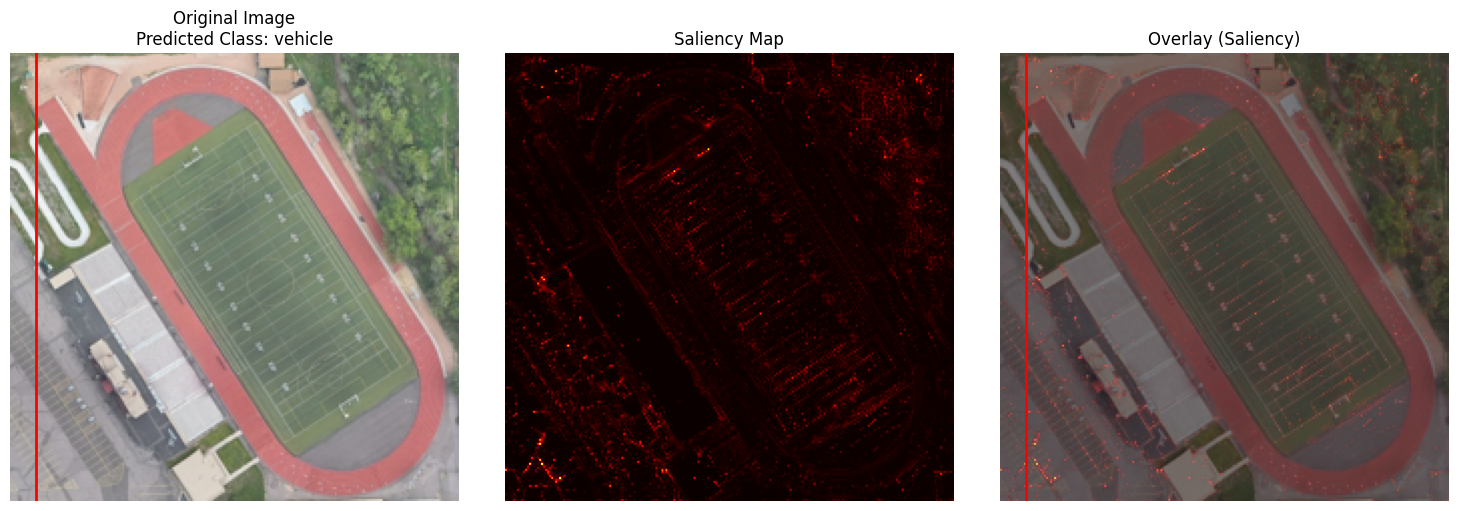

Predicted class: vehicle (9)
Number of objects in image: 1
Saliency map range: 0.0000 to 0.0178


In [18]:
# Test the visualization with different methods
show_attribution_with_box(model, datasets_dict['test'], idx=13, method='saliency')

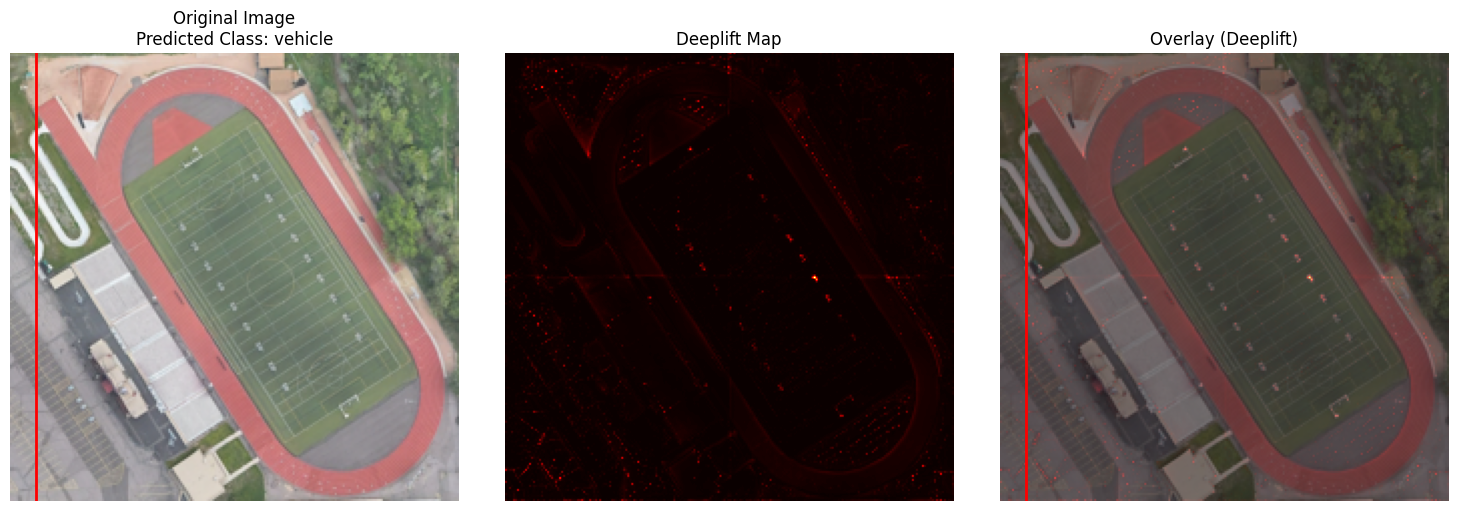

Predicted class: vehicle (9)
Number of objects in image: 1
Saliency map range: 0.0000 to 0.0309


In [19]:
show_attribution_with_box(model, datasets_dict['test'], idx=13, method='deeplift')

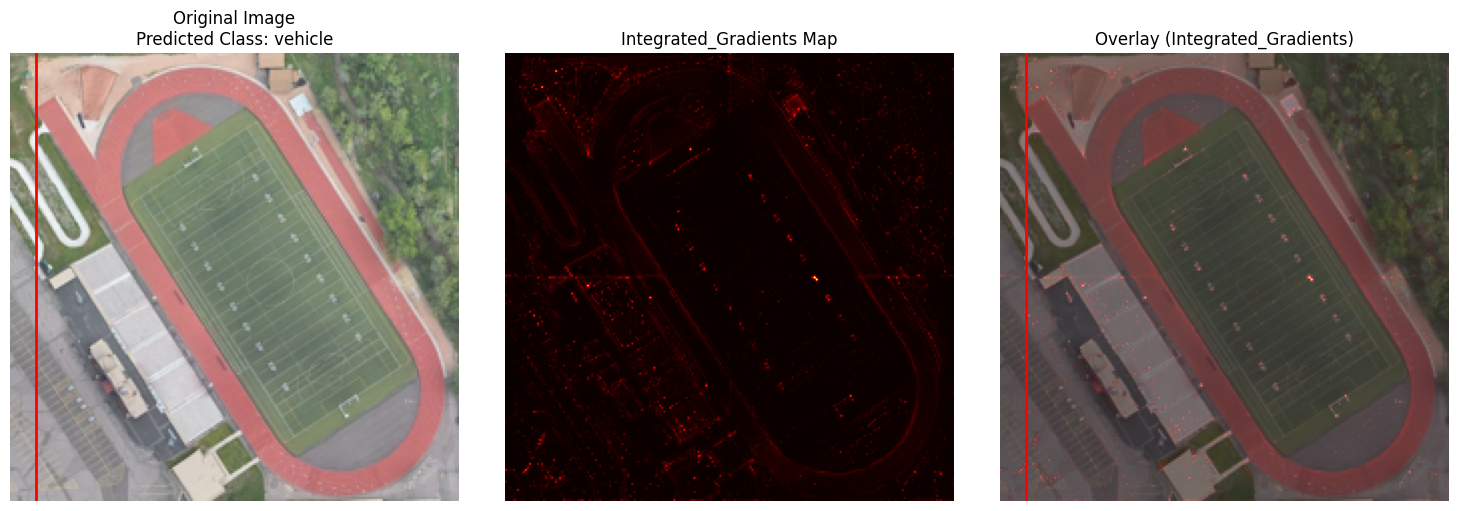

Predicted class: vehicle (9)
Number of objects in image: 1
Saliency map range: 0.0000 to 0.0437


In [20]:
show_attribution_with_box(model, datasets_dict['test'], idx=13, method='integrated_gradients')

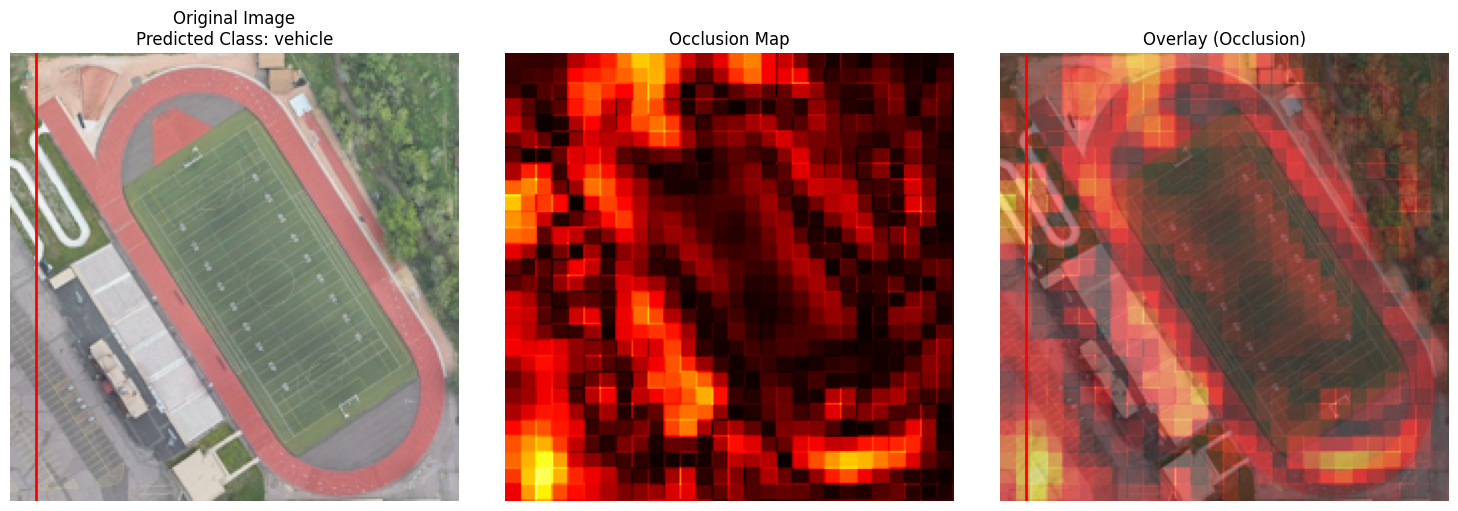

Predicted class: vehicle (9)
Number of objects in image: 1
Saliency map range: 0.0000 to 0.0725


In [21]:
show_attribution_with_box(model, datasets_dict['test'], idx=13, method='occlusion')

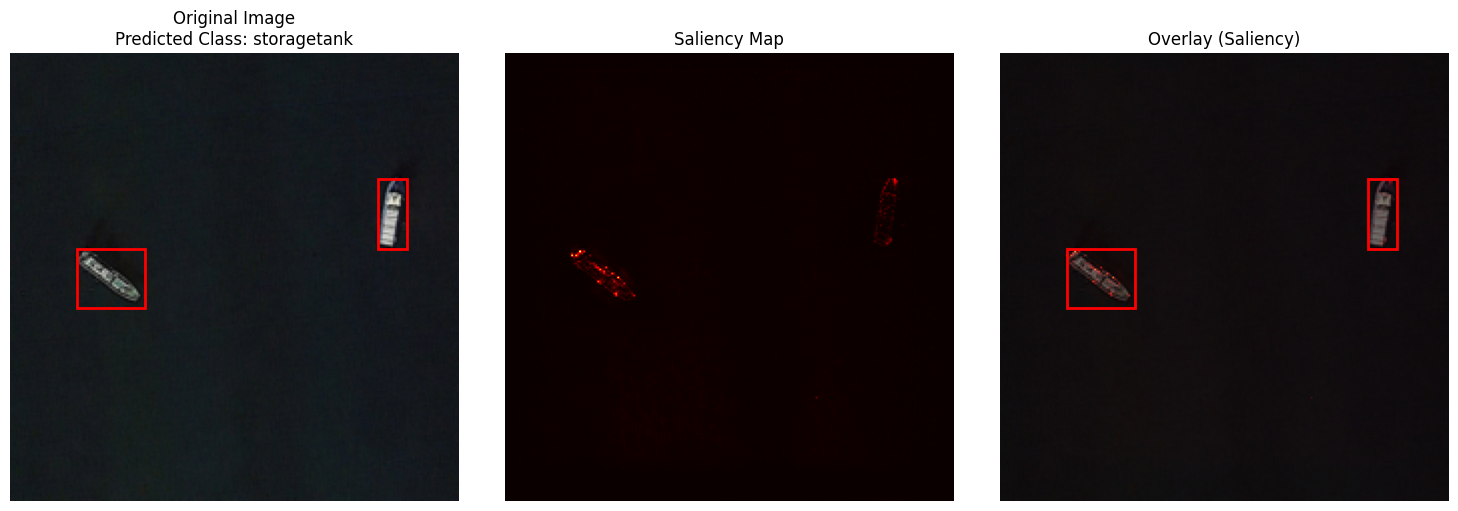

Predicted class: storagetank (7)
Number of objects in image: 2
Saliency map range: 0.0000 to 0.0140


In [22]:
show_attribution_with_box(model, datasets_dict['test'], idx=14, method='saliency')

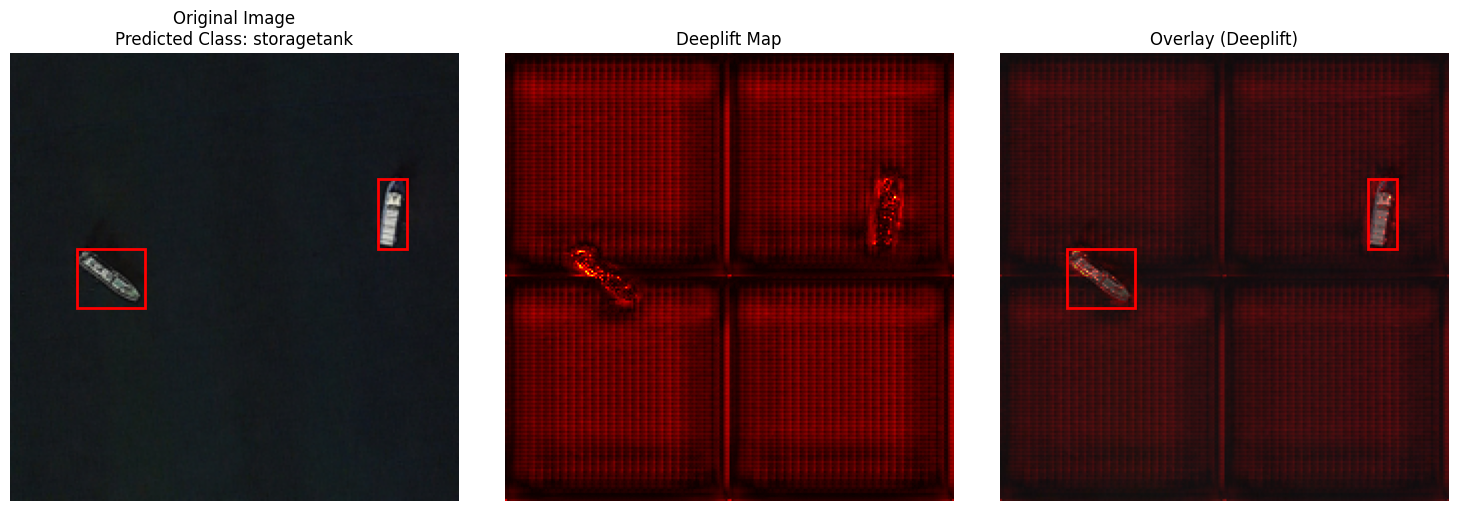

Predicted class: storagetank (7)
Number of objects in image: 2
Saliency map range: 0.0000 to 0.0025


In [25]:
show_attribution_with_box(model, datasets_dict['test'], idx=14, method='deeplift')

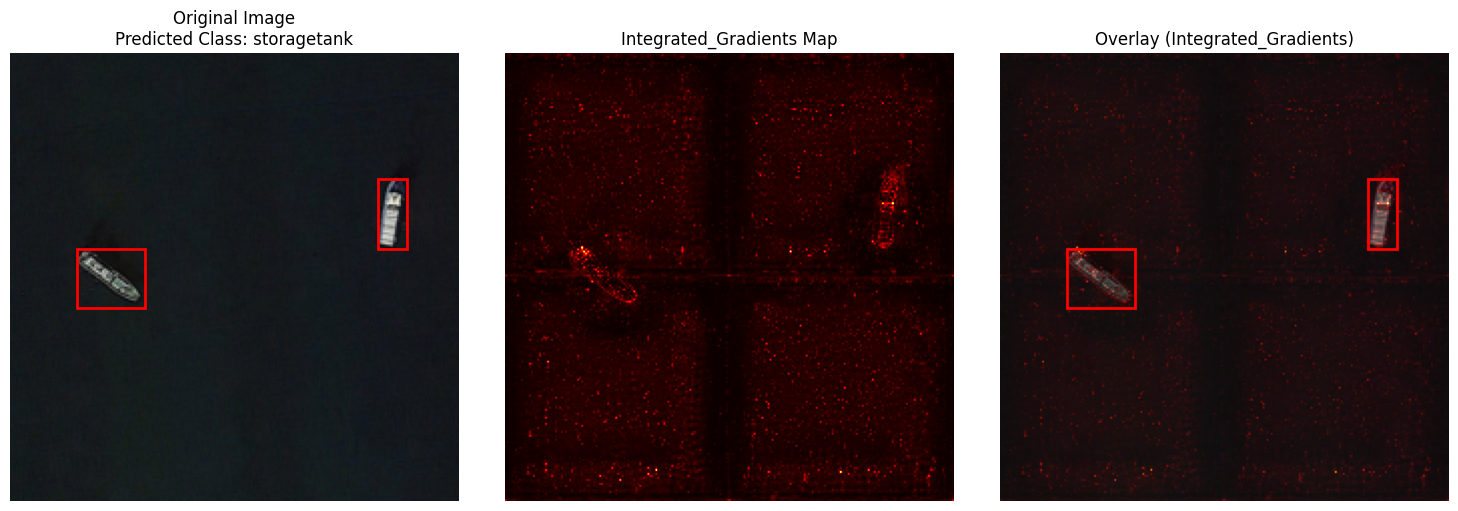

Predicted class: storagetank (7)
Number of objects in image: 2
Saliency map range: 0.0000 to 0.0285


In [26]:
show_attribution_with_box(model, datasets_dict['test'], idx=14, method='integrated_gradients')

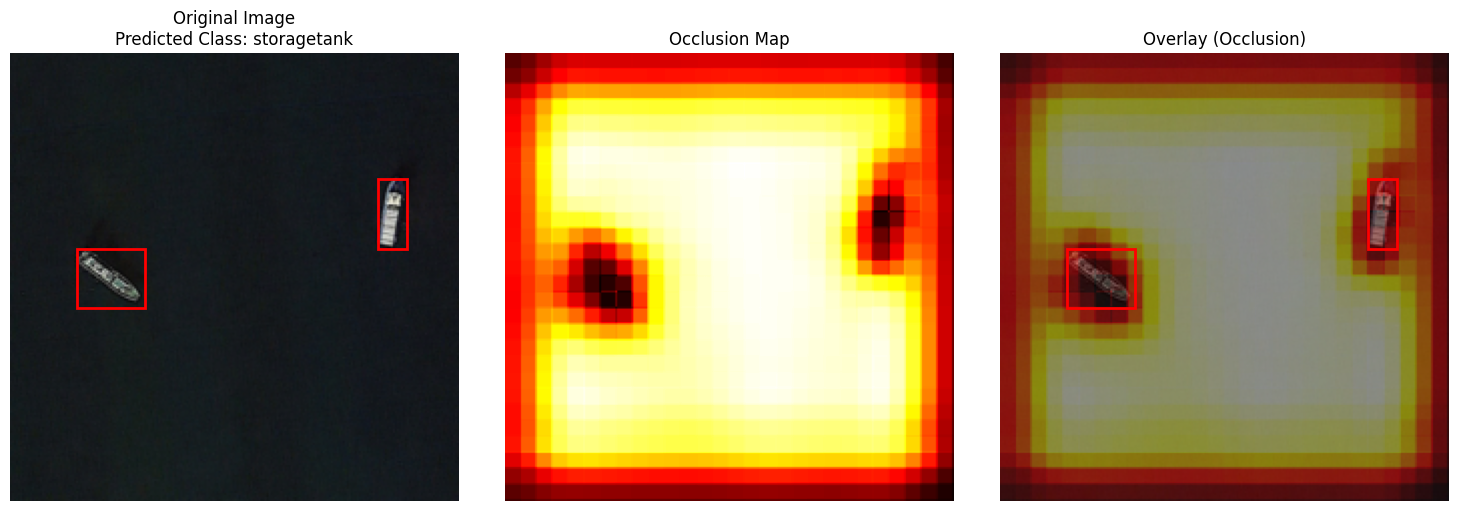

Predicted class: storagetank (7)
Number of objects in image: 2
Saliency map range: 0.0006 to 0.1340


In [27]:
show_attribution_with_box(model, datasets_dict['test'], idx=14, method='occlusion')